# Analysis of Staining Data
In this notebook I am extracting cell counts from csv files, plotting them in different groupings and performing statistical tests.
The raw data used here are manual cell counts of mouse cochlea cryosections (14 microns). In total, N = 6 animals were stained for Lypd1 transcript (marker for Type Ic SGNs, stained using in situ hybridization RNAscope) as well as for Calb2 (marker for Type Ia and Type Ib SGNS, with higher expression in Type Ia, stained using a secondary antibody system).

There are two groupings in the data:
- Age (N = 3 animals for 3 months and 16 months respectively)
- cochlea region (the position along the cochlea, basal, middle, and apical)

Not all sections are clean enough to allow for reliable differentiation between base/middle/apex and so some sections will have "NA" as a value in the "region" column. I am carrying out a comparative analysis for Type Ic cell percentage globally (meaning: for the whole section, without regard for subregions) and one that is region dependent with only the sections that provide good enough separation of the regions.

In [1]:
# Importing necessary modules for ...
# ... data processing ...
import numpy as np
import pandas as pd
import scipy.stats as st

# ... plotting ...
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc_context
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as fm
import seaborn as sns

# ... file reading/writing
import os, sys

### Plotting Configuration

This cell is only for making pretty plots.

In [4]:
# Defining custom color map for plots
with open(r".\Resources\ColorMap.csv", "r") as file:
    my_cmap_df = pd.read_csv(file, header=0)
    my_cmap = ListedColormap(my_cmap_df["HEX_Code"].to_list())

# Defining save location for plots
figures_folder = r".\Plots\\"

# Defining folder where raw data is stored
data_folder = r".\Data\Cell_Counts\\"

# Adding custom font
fonts= [r"Resources\Arimo\Arimo-Regular.ttf",
        r".\Resources\Arimo\Arimo-SemiBold.ttf",
        r".\Resources\Arimo\Arimo-Italic.ttf",
        r".\Resources\Arimo\Arimo-SemiBoldItalic.ttf"]
for font in fonts:
    fm.fontManager.addfont(font)

scale = 1.4 #plot scale factor
fig_width = 2.35*scale

plt.rcParams["font.family"] = "Arimo"
plt.rcParams["figure.facecolor"] = (1.0, 1.0, 1.0, 0.0)
plt.rcParams["axes.labelsize"] = 6*scale
plt.rcParams["axes.labelweight"] = "semibold"
plt.rcParams["axes.facecolor"] = (1.0, 1.0, 1.0, 0.7)
plt.rcParams["xtick.labelsize"] = 6*scale
plt.rcParams["ytick.labelsize"] = 6*scale
plt.rcParams["axes.titlesize"] = 8*scale
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams["axes.titleweight"] = "semibold"
plt.rcParams["legend.fontsize"] = 6*scale

## Locating Data
All raw data files must be in a folder. Enter the full path of that folder here.
The full paths of all the contained child items (raw data files) are then stored as strings in a python list for later reading.

In [6]:
# Locating data on drive
file_paths = []
for file_name in os.listdir(data_folder):
    file_paths.append(os.path.join(data_folder, file_name))

## Reading Raw Data
Reading all the raw data from the data files in the `file_paths` list.
Data is being written into pandas dataframes. all the individual files are concatenated together into one dataframe where every observation has the following variables:
- Section number (indicating wheather counts originate from the same cryosection)
- Lypd+ (cells counted positive for Lypd, Type Ic SGNs)
- Calb2+ (cells counted positive for Calb2, Type Ia + b SGNs)
- Region (basal, middle, apex, or NaN for sections that were too broken to determine a region)
- Age (3 months or 16 months)

In [7]:
# Creating empty pandas data frame
pandaf = pd.DataFrame()

# files are all appended to the data frame and annotated with their respective age group
for file in file_paths:
    data = pd.read_csv(file, skiprows=1)
    if "3mo" in file:
        data["Age"] = "3 months"
    elif "16mo" in file:
        data["Age"] = "16 months"
    pandaf = pd.concat([pandaf, data])

# Changin indices back to unique
pandaf.reset_index(drop= True, inplace= True)

pandaf

,Section,Lypd+,Calb2+,Region,Complete,Age
0,1,32,57,NaN,NaN,3 months
1,2,80,134,NaN,NaN,3 months
2,3,35,76,NaN,NaN,3 months
3,4,17,32,base,1.0,3 months
4,4,27,40,middle,1.0,3 months
...,...,...,...,...,...,...
186,21,35,31,base,1.0,16 months
187,21,45,58,middle,1.0,16 months
188,21,18,23,apex,1.0,16 months
189,22,34,82,base,0.0,16 months


## Transforming dataframe
We add a column containing the percent fraction of Lypd1+ cells for each observation. We also create a copy of the dataframe that only includes sections that have a clear base/middle/apex region for later tonotopic analysis.

In [8]:
# Generating a new dataframe that only contains total values per section, without regard for regions
pandaf_total = pandaf.iloc[0:0].copy()
section = 1
last = 0
lypd, calb = [0,0]
for i in pandaf.index:
    if i == 0:
        continue
    if section != pandaf.loc[i, "Section"]:
        lypd = pandaf.loc[last:i-1]["Lypd+"].sum()
        calb = pandaf.loc[last:i-1]["Calb2+"].sum()
        pandaf_total = pd.concat([pandaf_total,
                                  pd.DataFrame({'Section': section,
                                                'Lypd+': [lypd],
                                                'Calb2+': [calb],
                                                'Age': pandaf.loc[i-1, "Age"]})])
        last = i
    else:
        continue
    section = pandaf.loc[i, "Section"]
pandaf_total.reset_index()

# Creating a new dataframe containing only sections with clear regional differentiation
pandaf_regions = pandaf[(pandaf["Region"].notna()) & pandaf["Complete"] == 1].copy()
pandaf_regions.reset_index()

# Calculating a new column with the percentages
pandaf_total["Lypd_fraction"] =     (pandaf_total["Lypd+"] / (pandaf_total["Calb2+"] + pandaf_total["Lypd+"])) * 100
pandaf_regions["Lypd_fraction"] =   (pandaf_regions["Lypd+"] / (pandaf_regions["Calb2+"] + pandaf_regions["Lypd+"])) * 100

descriptives_total = pandaf_total.groupby("Age").agg({"Lypd_fraction": ["count", "sem", "mean", "std"]})
descriptives_regional = pandaf_regions.groupby(["Age", "Region"]).agg({"Lypd_fraction": ["count", "sem", "mean", "std"]})
print(descriptives_total)
print(descriptives_regional)

          Lypd_fraction                               
                  count       sem       mean       std
Age                                                   
16 months            61  1.252338  43.405517  9.781071
3 months             46  1.292488  42.970411  8.766081
                 Lypd_fraction                                
                         count       sem       mean        std
Age       Region                                              
16 months apex              21  1.633794  40.246952   7.486984
          base              21  1.089972  46.070780   4.994881
          middle            21  1.329737  40.255692   6.093621
3 months  apex              10  3.377552  43.918042  10.680759
          base              10  2.532528  46.213067   8.008556
          middle            10  1.908651  41.350920   6.035686


## Plotting
Creating bar plots to compare age groups. Once for the whole cochlea and once split after regions.

112.0 0.9186935424804688


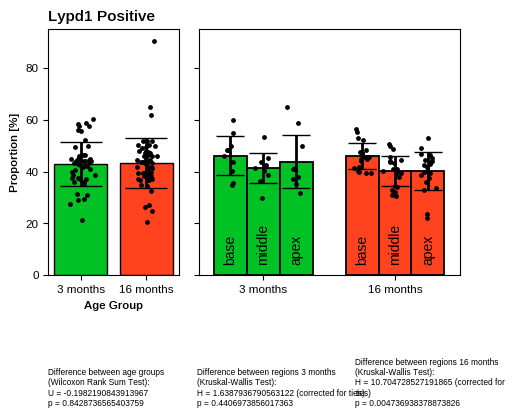

In [10]:
data = {"3 months":
        {"total":    pandaf_total.loc[pandaf_total["Age"] == "3 months", "Lypd_fraction"].to_list(),
         "base":     pandaf_regions.loc[(pandaf_regions["Region"] == "base") & (pandaf_regions["Age"] == "3 months"), "Lypd_fraction"].to_list(),
         "middle":   pandaf_regions.loc[(pandaf_regions["Region"] == "middle") & (pandaf_regions["Age"] == "3 months"), "Lypd_fraction"].to_list(),
         "apex":     pandaf_regions.loc[(pandaf_regions["Region"] == "apex") & (pandaf_regions["Age"] == "3 months"), "Lypd_fraction"].to_list()},
         "16 months":
         {"total":   pandaf_total.loc[pandaf_total["Age"] == "16 months", "Lypd_fraction"].to_list(),
          "base":    pandaf_regions.loc[(pandaf_regions["Region"] == "base") & (pandaf_regions["Age"] == "16 months"), "Lypd_fraction"].to_list(),
          "middle":  pandaf_regions.loc[(pandaf_regions["Region"] == "middle") & (pandaf_regions["Age"] == "16 months"), "Lypd_fraction"].to_list(),
          "apex":    pandaf_regions.loc[(pandaf_regions["Region"] == "apex") & (pandaf_regions["Age"] == "16 months"), "Lypd_fraction"].to_list()}}

fig, axs = plt.subplots(1,2, figsize = (fig_width*1.6, fig_width*1.2),
                        width_ratios= [1,2],
                        layout= 'tight',
                        sharey= True,
                        sharex= True)

# Bar plot of the two age groups
axs[0].bar(x= ["3 months", "16 months"],
           height= [np.mean(data["3 months"]["total"]),
                    np.mean(data["16 months"]["total"])],
            color = my_cmap.colors[4:],
            edgecolor = "black",
            linewidth = 1,
            yerr= [np.std(data["3 months"]["total"]),
                   np.std(data["16 months"]["total"])],
            error_kw= {"ecolor": "black",
                       "elinewidth": 2,
                       "capsize": 15})

# Jitter points over top the bar plots
axs[0].scatter(np.random.normal(0, 0.08, (1,len(data["3 months"]["total"])))[0].tolist(), data["3 months"]["total"],
               color = "black",
               s = 6)
axs[0].scatter(np.random.normal(1, 0.08, (1,len(data["16 months"]["total"])))[0].tolist(), data["16 months"]["total"],
               color = "black",
               s = 6)
axs[0].set_ylabel("Proportion [%]")
axs[0].set_title("Lypd1 Positive")
axs[0].set_xlabel("Age Group")


width = 0.25
for i, age in enumerate(data.keys()):
    for j, region in zip([-1, 0, 1], list(data["3 months"].keys())[1:]):
        axs[1].bar(i + j*width,
                   np.mean(data[age][region]),
                   width = width,
                   color= my_cmap.colors[i+4],
                   edgecolor= "black",
                   linewidth = 1.3,
                   yerr= np.std(data[age][region]),
                   error_kw= {"ecolor": "black",
                              "linewidth": 2,
                              "capsize": 10})
        axs[1].scatter(np.random.normal(i + j*width, 0.035, (1,len(data[age][region])))[0].tolist(), data[age][region],
               color = "black",
               s = 6)
        axs[1].text((i + j*width), 5,
                    region,
                    ha= "center",
                    rotation = "vertical")

# Computing statistics between groups
stat, pval = st.ranksums(data["3 months"]["total"], data["16 months"]["total"])
data["stats_total"] = {"stat": stat,
                       "pval": pval}

for age in ["3 months", "16 months"]:
       stat, pval = st.kruskal(data[age]["base"],
                            data[age]["middle"],
                            data[age]["apex"])
       data[f"stats_{age}"] = {"stat": stat,
                               "pval": pval}

txt1= f"Difference between age groups\n(Wilcoxon Rank Sum Test):\nU = {data["stats_total"]["stat"]}\np = {data["stats_total"]["pval"]}"
txt2= f"Difference between regions 3 months\n(Kruskal-Wallis Test):\nH = {data["stats_3 months"]["stat"]} (corrected for ties)\np = {data["stats_3 months"]["pval"]}"
txt3= f"Difference between regions 16 months\n(Kruskal-Wallis Test):\nH = {data["stats_16 months"]["stat"]} (corrected for ties)\np = {data["stats_16 months"]["pval"]}"
axs[0].text(-0.5, -50, txt1, wrap=True, horizontalalignment='left', fontsize=6)
axs[1].text(-0.5, -50, txt2, wrap=True, horizontalalignment='left', fontsize=6)
axs[1].text(0.7, -50, txt3, wrap=True, horizontalalignment='left', fontsize=6)

stat, pval = st.wilcoxon(data["16 months"]["middle"], data["16 months"]["apex"], correction= True)
print(stat, pval)

fig.savefig(figures_folder + r"Staining_Data_3-16months.png", dpi= 600)
plt.show()

In [ ]:
# Figuring out n of sections included
print(f"3 months number of sections with intact regions: {len(data["3 months"]["apex"])}")
print(f"16 months number of sections with intact regions: {len(data["16 months"]["apex"])}")

3 months number of sections with intact regions: 10
16 months number of sections with intact regions: 21


### END OF SCRIPT
This notebook was created by *Johann Korn* on 02-10-2025.